In [139]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore")

In [140]:
data = pd.read_csv("municipality_bus_utilization.csv")
data.head(3)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893


In [141]:
def get_weekday(timestamp:str):
  return datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').weekday()

def get_hour(timestamp:str):
  return datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').hour

def get_month(timestamp:str):
  return datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').month

In [142]:
data["usage_rate"] = data.usage / data.total_capacity
data["weekday"] = data.timestamp.apply(get_weekday)
data["hour"] = data.timestamp.apply(get_hour)
data["month"] = data.timestamp.apply(get_month)

municipality_count = len(set(data.municipality_id))
municipality_data = {}

for m_id in range(municipality_count):
  municipality_data[m_id] = data[data.municipality_id == m_id]

In [143]:
municipality_data[0].head(3)

,timestamp,municipality_id,usage,total_capacity,usage_rate,weekday,hour,month
3,2017-06-04 07:59:42,0,204,2813,0.072520,6,7,6
18,2017-06-04 08:25:42,0,247,2813,0.087807,6,8,6
29,2017-06-04 08:59:42,0,332,2813,0.118023,6,8,6


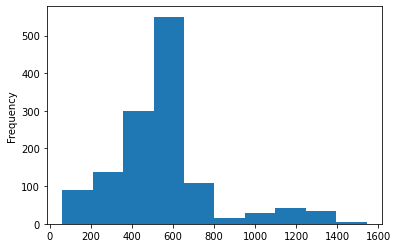

In [12]:
municipality_data[0].usage.plot.hist()

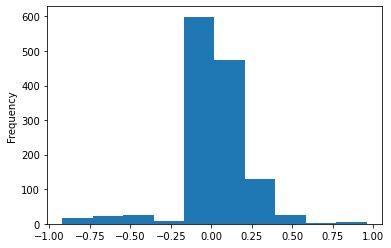

In [13]:
municipality_data[0].usage.pct_change().plot.hist()

usage follows an obvious pattern

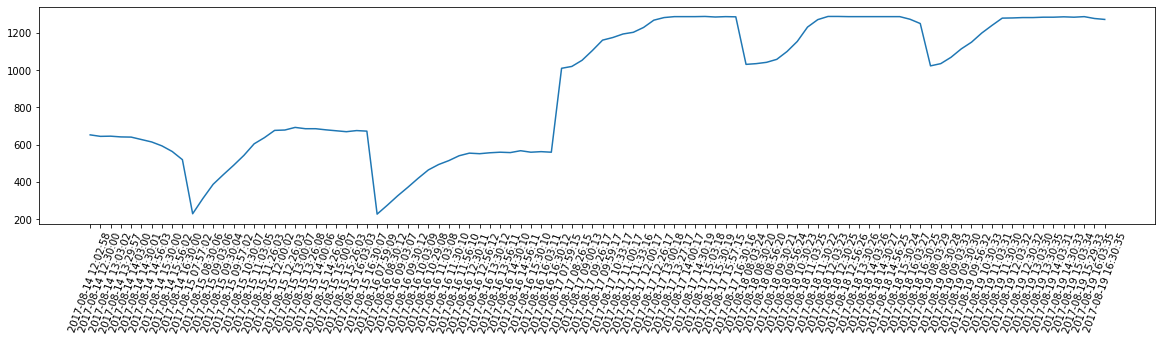

In [14]:
plt.figure(figsize=(20,4))
plt.plot(municipality_data[1].timestamp[-100:], municipality_data[0].usage[-100:])
plt.xticks(rotation=70)
plt.show()

In [144]:
def get_dataset(m_data, test_start="2017-08-05", test_end="2017-08-19"):
  test_set = m_data[(m_data.timestamp > "2017-08-05") & (m_data.timestamp < "2017-08-19")]
  train_set = m_data[m_data.timestamp < test_start]

  return train_set, test_set

In [145]:
def split_set(dataset, drop_cols=["timestamp", "municipality_id"], target_col="usage", horizon=1):
  X = dataset.drop(drop_cols, axis=1)
  y = X[target_col].shift(-1*horizon)

  return np.array(X)[1:-1], y[1:-1]

# Baseline

I didn't scale the data for the baseline model and didn't scale also for the tree based models because scaling didn't effect the result while using tree based models.

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

base_errors = []
for m_id in list(municipality_data.keys()):
  train_set, test_set = get_dataset(municipality_data[m_id])
  X_train, y_train = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])
  X_test, y_test = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])

  regressor = LinearRegression().fit(X_train, y_train)
  predictions = regressor.predict(X_test)
  base_errors.append(mean_squared_error(y_test, predictions))

print("Average Error:", np.mean(base_errors)/municipality_count)

Average Error: 1045.7876707476748


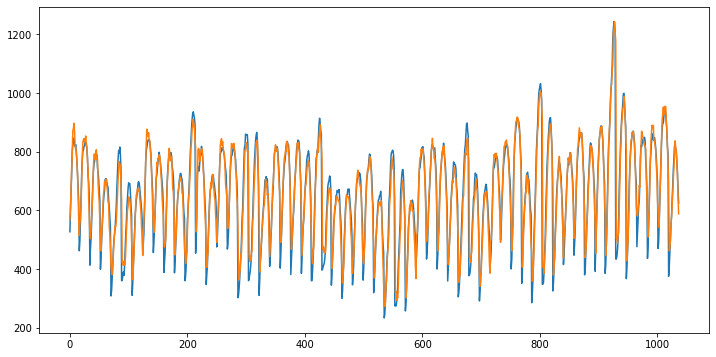

In [186]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions)

# Bayes

In [239]:
from sklearn.naive_bayes import GaussianNB

bayes_errors = []
for m_id in list(municipality_data.keys()):
  train_set, test_set = get_dataset(municipality_data[m_id])
  X_train, y_train = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])
  X_test, y_test = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])

  bayes = GaussianNB().fit(X_train, y_train).fit(X_train, y_train)
  predictions = bayes.predict(X_test)
  bayes_errors.append(mean_squared_error(y_test, predictions))

print("Average Error:", np.mean(bayes_errors)/municipality_count)

Average Error: 721.7706364513018


# Tree Based

In [226]:
random.seed(10)

Average Error: 312.68443236369774


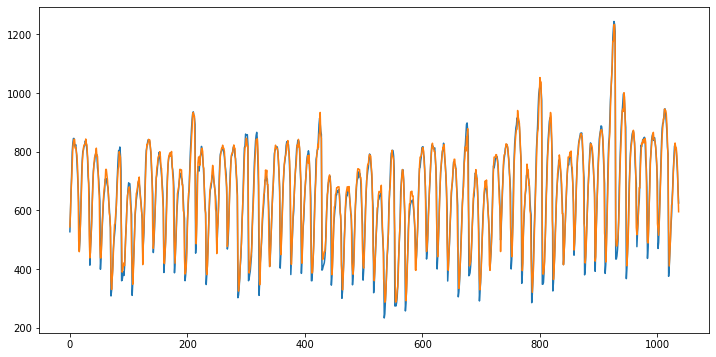

In [235]:
from xgboost import XGBRegressor
import random


xgb_errors = []
for m_id in list(municipality_data.keys()):
  train_set, test_set = get_dataset(municipality_data[m_id])
  X_train, y_train = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])
  X_test, y_test = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])

  xgb = XGBRegressor(silent=True, objective ='reg:squarederror', random_state=1).fit(X_train, y_train)
  predictions = xgb.predict(X_test)
  xgb_errors.append(mean_squared_error(y_test, predictions))

print("Average Error:", np.mean(xgb_errors)/municipality_count)

plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions)

In [209]:
from sklearn.metrics import f1_score

In [236]:
correct_directions = y_train.diff().shift(-1) > 0
p_directions = pd.DataFrame(predictions).diff().shift(-1) > 0
f1_score(correct_directions, p_directions, average="weighted")

0.8621291497721025

# Add lag to data with XGB

In [229]:
def generate_lag(data, lag_count = 17):
  for lag in range(lag_count):
    data["lag"+str(lag)] = data.usage.shift(lag)
  
  return data

In [237]:
from xgboost import XGBRegressor

for lag in range(1, 20, 5):
  xgb_errors = []
  for m_id in list(municipality_data.keys()):
    train_set, test_set = get_dataset(municipality_data[m_id])
    train_set = generate_lag(train_set, lag)
    test_set = generate_lag(test_set, lag)

    X_train, y_train = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])
    X_test, y_test = split_set(train_set, drop_cols=["timestamp", "municipality_id", "total_capacity", "usage_rate"])

    xgb = XGBRegressor(silent=True, objective ='reg:squarederror', random_state=1).fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    xgb_errors.append(mean_squared_error(y_test, predictions))

  print("Lag Count:", lag, "Average Error:", np.mean(xgb_errors)/municipality_count)

Lag Count: 1 Average Error: 312.68443236369774
Lag Count: 6 Average Error: 217.9919616913678
Lag Count: 11 Average Error: 208.34919927915143
Lag Count: 16 Average Error: 156.1561445956671


In [238]:
correct_directions = y_train.diff().shift(-1) > 0
p_directions = pd.DataFrame(predictions).diff().shift(-1) > 0
f1_score(correct_directions, p_directions, average="weighted")

0.8758513565813483

# Deep Learning (2 branch, CNN combined with dense)

In [ ]:
import tensorflow as tf
from tensorflow import keras

dl_errors = []
for m_id in list(municipality_data.keys()):
  train_set, test_set = get_dataset(municipality_data[m_id])

  usage_data = train_set.usage
  tabular_data = train_set[["hour", "weekday", "month"]]

  std = np.std(usage_data, axis=0)
  mean =  np.mean(usage_data, axis=0)

  usage_data = (usage_data - mean) / std
  usage_data = np.expand_dims(usage_data, axis=-1)

  target = pd.DataFrame(usage_data).shift(-1)
  usage_data = pd.DataFrame(usage_data, columns=["usage"])

  usage_data = generate_lag(usage_data)
  usage_data.dropna(inplace=True)

  # build the time series branch
  time_series_input = keras.layers.Input(shape=(usage_data.shape[1], 1))
  x = keras.layers.Conv1D(64, 5, activation='relu')(time_series_input)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Conv1D(32, 3, activation='relu')(x)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Flatten()(x)
  time_series_output = keras.layers.Dense(16, activation='relu')(x)

  # build the tabular branch
  tabular_input = keras.layers.Input(shape=(tabular_data.shape[1],))
  x = keras.layers.Dense(32, activation='relu')(tabular_input)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(16, activation='relu')(x)
  tabular_output = keras.layers.Dropout(0.5)(x)

  # combine the branches
  combined = keras.layers.concatenate([time_series_output, tabular_output])
  x = keras.layers.Dense(32, activation='relu')(combined)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(16, activation='relu')(x)
  output = keras.layers.Dense(1, activation='linear')(x)

  # build the model
  model = keras.models.Model(inputs=[time_series_input, tabular_input], outputs=output)
  model.compile(loss='mean_squared_error', optimizer='adam')

  # train the model
  model.fit([usage_data, tabular_data], target, epochs=50, batch_size=32, validation_split=0.2, verbose=3)


  usage_data_test = test_set.usage
  tabular_data_test = test_set[["hour", "weekday", "month"]]

  usage_data_test = (usage_data_test - mean) / std
  usage_data_test = np.expand_dims(usage_data_test, axis=-1)

  usage_data_test = pd.DataFrame(usage_data_test, columns=["usage"])
  usage_data_test = generate_lag(usage_data_test)

  predictions = model.predict([usage_data_test, tabular_data_test])  
  reversed_data = (usage_data_test.usage*std)+mean
  reversed_preds = (predictions*std)+mean

  dl_errors.append(mean_squared_error(reversed_data[-len(pd.DataFrame(reversed_preds).dropna()):], 
                                      pd.DataFrame(reversed_preds).dropna()))

In [178]:
"Average Error:", np.mean(dl_errors)

('Average Error:', 120543.56959535842)

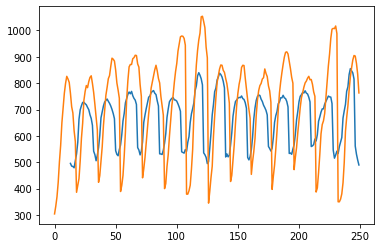

In [179]:
reversed_data = (usage_data_test.usage*std)+mean
reversed_preds = (predictions*std)+mean

plt.plot(reversed_preds)
plt.plot(reversed_data)
plt.show()

In general using XGBoost with lags gave the best test result in terms of MSE (improved the mse success more than x2). Correct direction prediction f1 score is %87.5 which is approximately %1 more than without lagged version (which was %86.2).